## Threshold Visualization

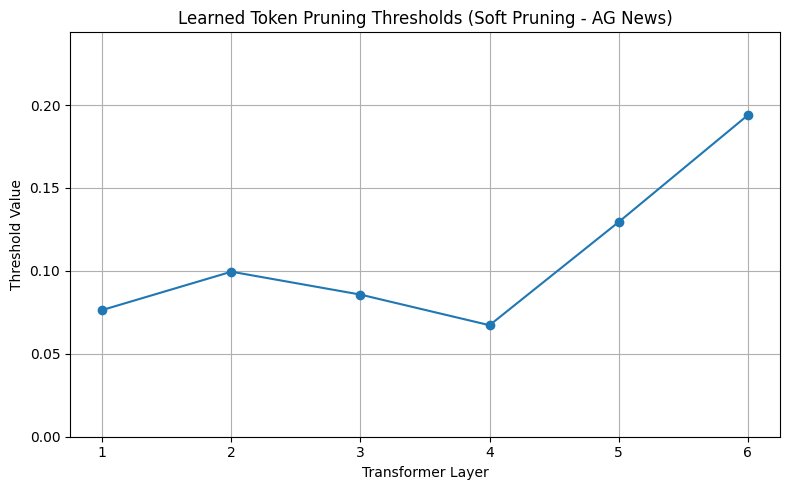

In [ ]:
## threshold visulaization

import matplotlib.pyplot as plt
import numpy as np

# Threshold values for each layer after soft pruning
# Threshold values are from file "model_pipeline_agnews.ipynb"
thresholds = np.array([0.07640352, 0.09950283, 0.08569011, 0.06723312 ,0.12944147 ,0.19382311])

# Create layer indices
layers = np.arange(1, len(thresholds) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(layers, thresholds, marker='o')
plt.title("Learned Token Pruning Thresholds (Soft Pruning - AG News)")
plt.xlabel("Transformer Layer")
plt.ylabel("Threshold Value")
plt.grid(True)
plt.xticks(layers)
plt.ylim(0, max(thresholds) + 0.05)
plt.tight_layout()
plt.show()

## Cleaning the remaining tokens by removing stopwords and meaningless tokens

In [5]:
import pandas as pd
import string
import re
from nltk.corpus import stopwords
import nltk

# Make sure you have stopwords downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load your CSV
df = pd.read_csv('agnews_predictions_with_pruned.csv')

# Function to clean a sentence
def clean_text(text):
    if pd.isna(text):
        return ""
    # Lowercase
    text = text.lower()
    # Remove punctuation and digits
    text = re.sub(rf"[{re.escape(string.punctuation)}0-9]", " ", text)
    # Tokenize and filter
    tokens = text.split()
    filtered_tokens = [
        token for token in tokens
        if token not in stop_words and len(token) > 1 and token.isalpha()
    ]
    return " ".join(filtered_tokens)

# Apply cleaning
df['cleaned_remaining_sentence'] = df['remaining_sentence'].apply(clean_text)

# Select only required columns
cleaned_df = df[['input_sentence', 'cleaned_remaining_sentence', 'predicted_label', 'true_label']]

# Save cleaned file
cleaned_df.to_csv('cleaned_agnews_pruned.csv', index=False)

print("✅ Cleaned file saved as 'cleaned_agnews_pruned.csv'")

✅ Cleaned file saved as 'cleaned_agnews_pruned.csv'


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christomathew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Frequency analysis 

Analyze the frequency of most repeated words among retained tokens

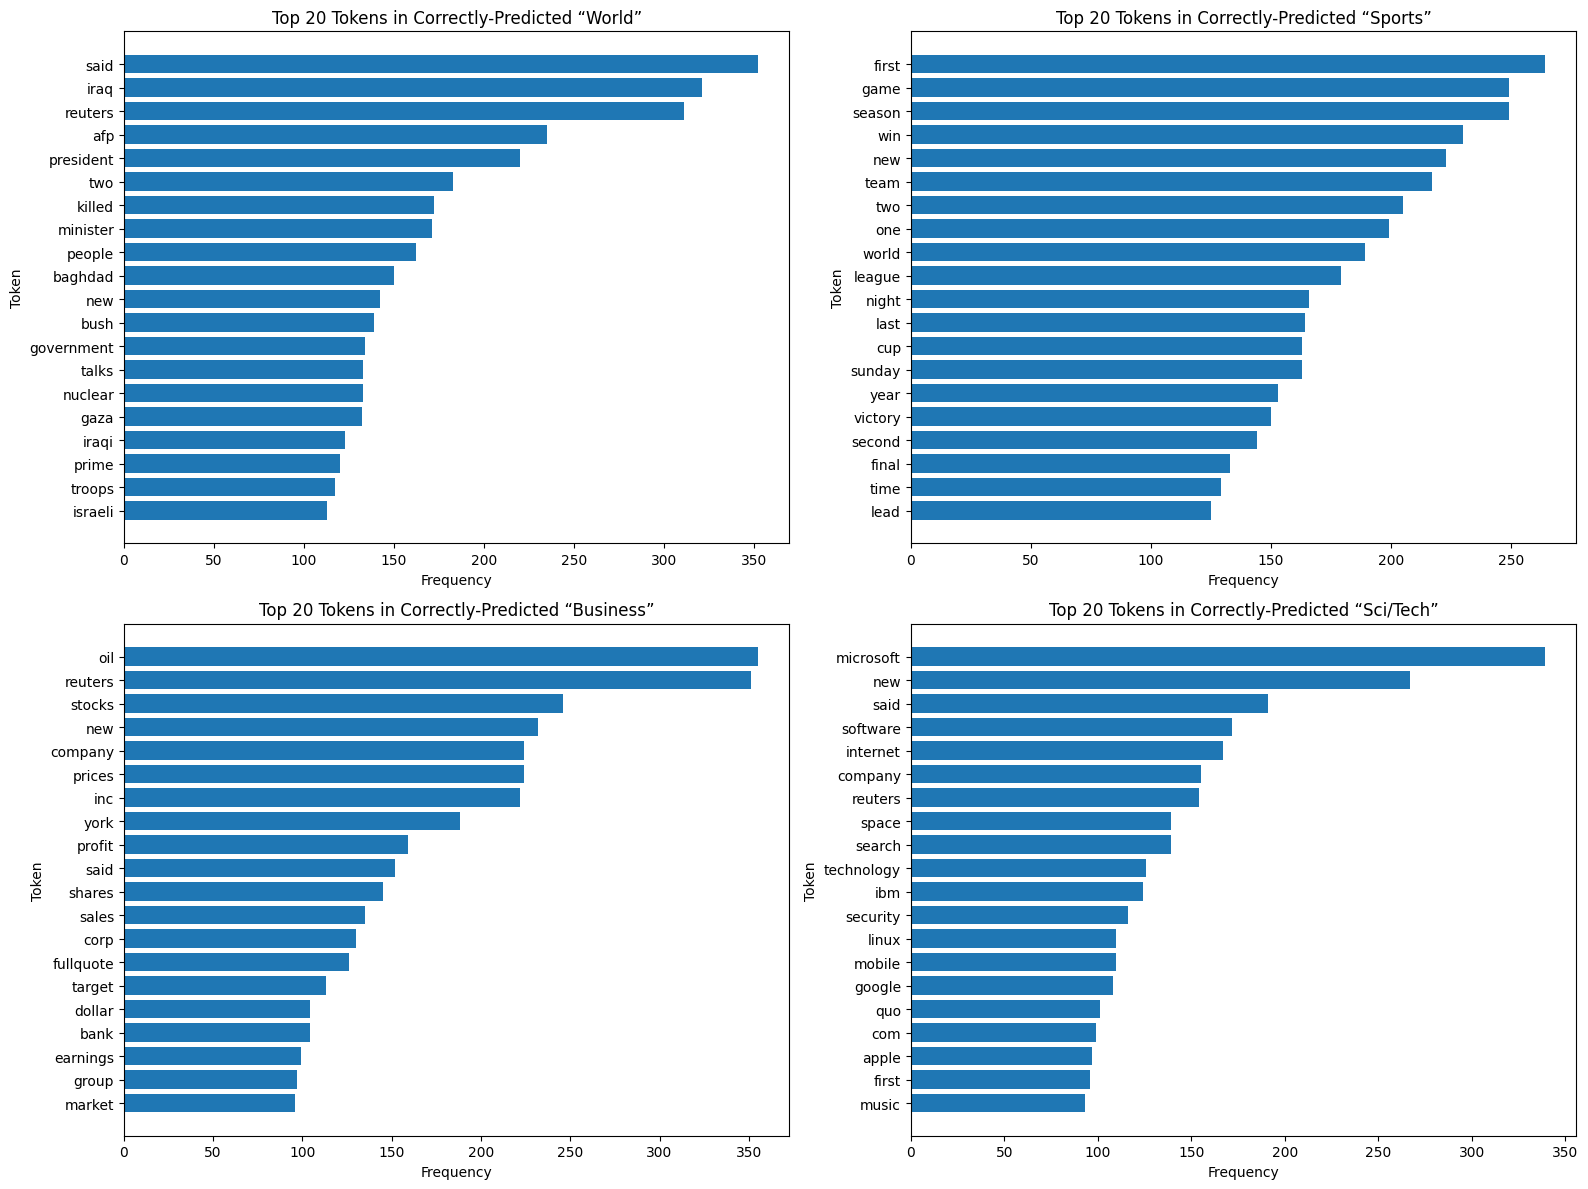

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the stopword‐filtered AG News pruning file
df = pd.read_csv('cleaned_agnews_pruned.csv')

# 2. Keep only the correctly predicted examples
df = df[df['predicted_label'] == df['true_label']]

# 3. Parse the cleaned retained‐tokens into real lists
df['retained_list'] = df['cleaned_remaining_sentence'].str.split()

# 4. Define a simple token filter to drop short or non‐alphabetic tokens
def is_meaningful(token):
    return token.isalpha() and len(token) > 2

# 5. Filter each retained‐tokens list
df['filtered_retained'] = df['retained_list'].apply(
    lambda toks: [t.lower() for t in toks if is_meaningful(t)]
)

# 6. Compute the top N tokens for each of the four true classes
label_names = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}
top_n = 20
class_counts = {}
for label in sorted(df['true_label'].unique()):
    counts = (
        df[df['true_label'] == label]['filtered_retained']
        .explode()
        .value_counts()
    )
    class_counts[label] = counts.nlargest(top_n)

# 7. Plot as a 2×2 grid of horizontal bar charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, label in enumerate(sorted(class_counts)):
    top_tokens = class_counts[label]
    ax = axes[idx]
    ax.barh(top_tokens.index[::-1], top_tokens.values[::-1])
    ax.set_title(f"Top {top_n} Tokens in Correctly-Predicted “{label_names[label]}”")
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Token")
    ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.savefig("results_agnews/plots/top_tokens_by_class.png", dpi=300)
plt.show()

### Classwise comparison of frequency of words in true positive and true negatives

### class 0- World

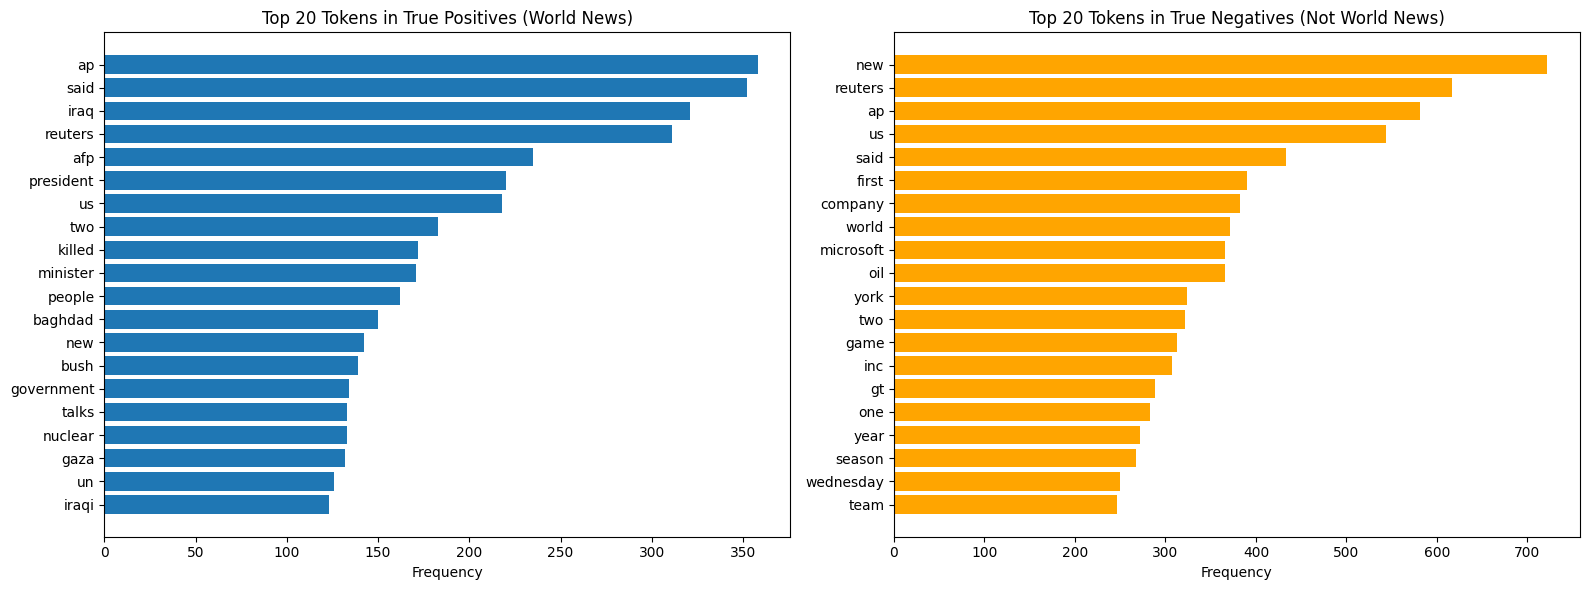

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

# Load your cleaned AG News CSV file
df = pd.read_csv('cleaned_agnews_pruned.csv')

# Clean NaNs
df = df.dropna(subset=['cleaned_remaining_sentence'])


# True Positives for class 1
true_positives = df[(df['true_label'] == 0) & (df['predicted_label'] == 0)]

# True Negatives for class 1 — everything else correctly predicted that's not class 2
true_negatives = df[(df['true_label'] != 0) & (df['true_label'] == df['predicted_label'])]

def get_top_tokens(dataframe, column='cleaned_remaining_sentence', top_k=20):
    all_tokens = []
    for sent in dataframe[column]:
        tokens = sent.lower().strip().split()
        all_tokens.extend(tokens)
    counter = Counter(all_tokens)
    return counter.most_common(top_k)

# Get top tokens
tp_top_tokens = get_top_tokens(true_positives)
tn_top_tokens = get_top_tokens(true_negatives)

# Save token counts to CSV
os.makedirs("results_agnews/token_counts", exist_ok=True)
pd.DataFrame(tp_top_tokens, columns=["token", "frequency"]).to_csv("results_agnews/token_counts/true_positives_class1_top20.csv", index=False)
pd.DataFrame(tn_top_tokens, columns=["token", "frequency"]).to_csv("results_agnews/token_counts/true_negatives_class1_top20.csv", index=False)

# Unpack for plotting
tp_tokens, tp_counts = zip(*tp_top_tokens) if tp_top_tokens else ([], [])
tn_tokens, tn_counts = zip(*tn_top_tokens) if tn_top_tokens else ([], [])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(range(len(tp_tokens)), tp_counts, align='center')
axes[0].set_yticks(range(len(tp_tokens)))
axes[0].set_yticklabels(tp_tokens)
axes[0].set_title("Top 20 Tokens in True Positives (World News)")
axes[0].invert_yaxis()
axes[0].set_xlabel("Frequency")

axes[1].barh(range(len(tn_tokens)), tn_counts, color='orange', align='center')
axes[1].set_yticks(range(len(tn_tokens)))
axes[1].set_yticklabels(tn_tokens)
axes[1].set_title("Top 20 Tokens in True Negatives (Not World News)")
axes[1].invert_yaxis()
axes[1].set_xlabel("Frequency")

plt.tight_layout()
os.makedirs("results_agnews/plots", exist_ok=True)
plt.savefig("results_agnews/plots/top20_tokens_TP_TN_class0.png")
plt.show()

### Class 1 - Sports

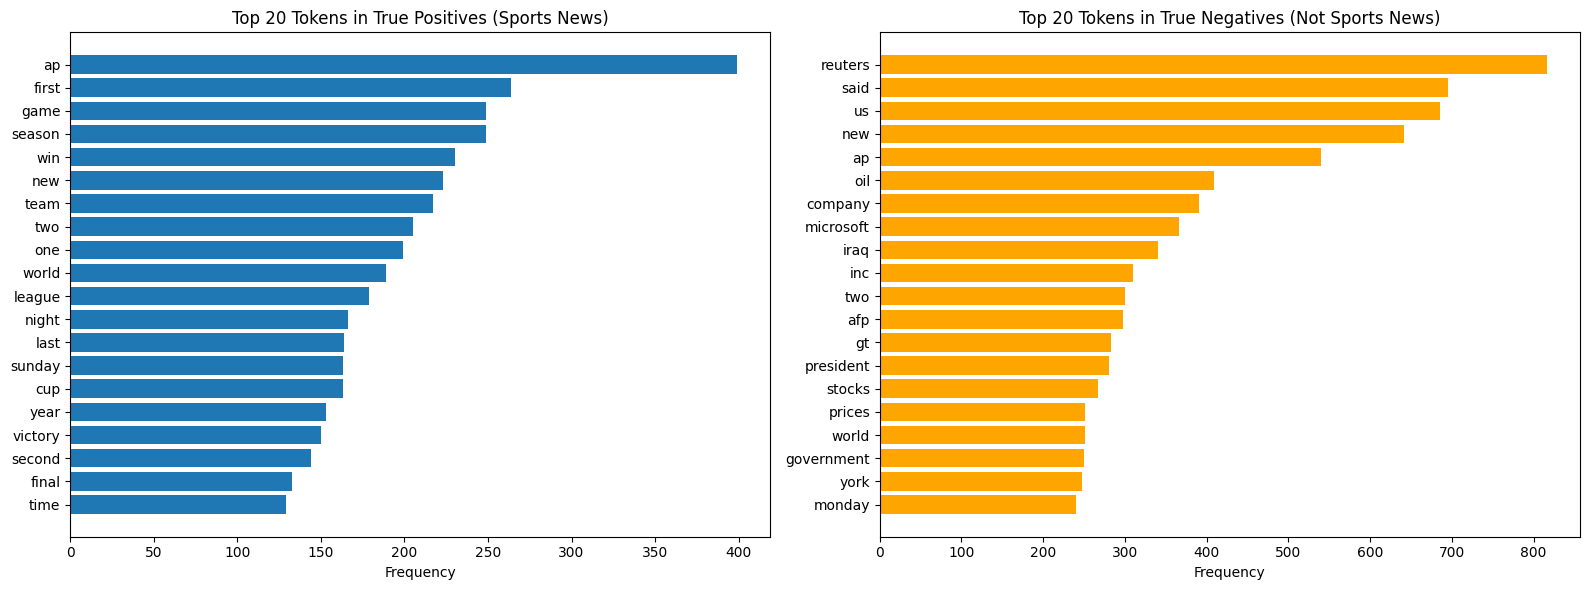

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

# Load your cleaned AG News CSV file
df = pd.read_csv('cleaned_agnews_pruned.csv')

# Clean NaNs
df = df.dropna(subset=['cleaned_remaining_sentence'])

# Filter: True Positives for class 0 (World News)
true_positives = df[(df['true_label'] == 1) & (df['predicted_label'] == 1)]

# Function to get top tokens
def get_top_tokens(dataframe, column='cleaned_remaining_sentence', top_k=20):
    all_tokens = []
    for sent in dataframe[column]:
        tokens = sent.lower().strip().split()
        all_tokens.extend(tokens)
    counter = Counter(all_tokens)
    return counter.most_common(top_k)

# Get top tokens
tp_top_tokens = get_top_tokens(true_positives)

# Save to CSV
os.makedirs("results_agnews/token_counts", exist_ok=True)
pd.DataFrame(tp_top_tokens, columns=["token", "frequency"]).to_csv(
    "results_agnews/token_counts/true_positives_class0_top20.csv", index=False
)

# Unpack for plotting
tp_tokens, tp_counts = zip(*tp_top_tokens) if tp_top_tokens else ([], [])

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(tp_tokens)), tp_counts, align='center', color='skyblue')
plt.yticks(range(len(tp_tokens)), tp_tokens)
plt.title("Top 20 Tokens in True Positives (Class 1 - Sports News)")
plt.gca().invert_yaxis()
plt.xlabel("Frequency")

plt.tight_layout()
os.makedirs("results_agnews/plots", exist_ok=True)
plt.savefig("results_agnews/plots/top20_tokens_TP_class1.png")
plt.show()

### Class 2 - Business

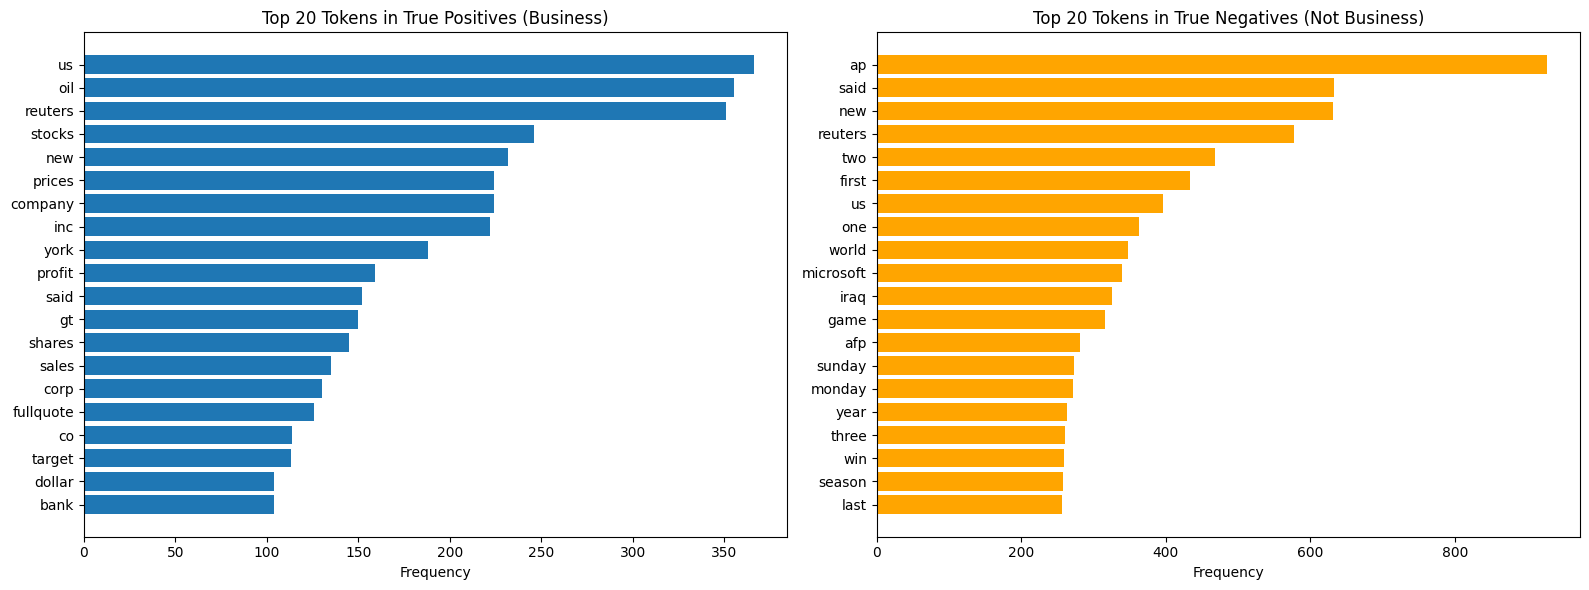

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

# Load your cleaned AG News CSV file
df = pd.read_csv('cleaned_agnews_pruned.csv')

# Clean NaNs
df = df.dropna(subset=['cleaned_remaining_sentence'])

# Example: Let's compare Business (e.g., Sports) predictions
# You can modify this depending on what classes you're interested in

# True Positives for Business
true_positives = df[(df['true_label'] == 2) & (df['predicted_label'] == 2)]

# True Negatives for Business — everything else correctly predicted that's not Business
true_negatives = df[(df['true_label'] != 2) & (df['true_label'] == df['predicted_label'])]

def get_top_tokens(dataframe, column='cleaned_remaining_sentence', top_k=20):
    all_tokens = []
    for sent in dataframe[column]:
        tokens = sent.lower().strip().split()
        all_tokens.extend(tokens)
    counter = Counter(all_tokens)
    return counter.most_common(top_k)

# Get top tokens
tp_top_tokens = get_top_tokens(true_positives)
tn_top_tokens = get_top_tokens(true_negatives)

# Save token counts to CSV
os.makedirs("results_agnews/token_counts", exist_ok=True)
pd.DataFrame(tp_top_tokens, columns=["token", "frequency"]).to_csv("results_agnews/token_counts/true_positives_class2_top20.csv", index=False)
pd.DataFrame(tn_top_tokens, columns=["token", "frequency"]).to_csv("results_agnews/token_counts/true_negatives_class2_top20.csv", index=False)

# Unpack for plotting
tp_tokens, tp_counts = zip(*tp_top_tokens) if tp_top_tokens else ([], [])
tn_tokens, tn_counts = zip(*tn_top_tokens) if tn_top_tokens else ([], [])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(range(len(tp_tokens)), tp_counts, align='center')
axes[0].set_yticks(range(len(tp_tokens)))
axes[0].set_yticklabels(tp_tokens)
axes[0].set_title("Top 20 Tokens in True Positives (Business)")
axes[0].invert_yaxis()
axes[0].set_xlabel("Frequency")

axes[1].barh(range(len(tn_tokens)), tn_counts, color='orange', align='center')
axes[1].set_yticks(range(len(tn_tokens)))
axes[1].set_yticklabels(tn_tokens)
axes[1].set_title("Top 20 Tokens in True Negatives (Not Business)")
axes[1].invert_yaxis()
axes[1].set_xlabel("Frequency")

plt.tight_layout()
os.makedirs("results_agnews/plots", exist_ok=True)
plt.savefig("results_agnews/plots/top20_tokens_TP_TN_class2.png")
plt.show()

### class 3 - Sci/Tech

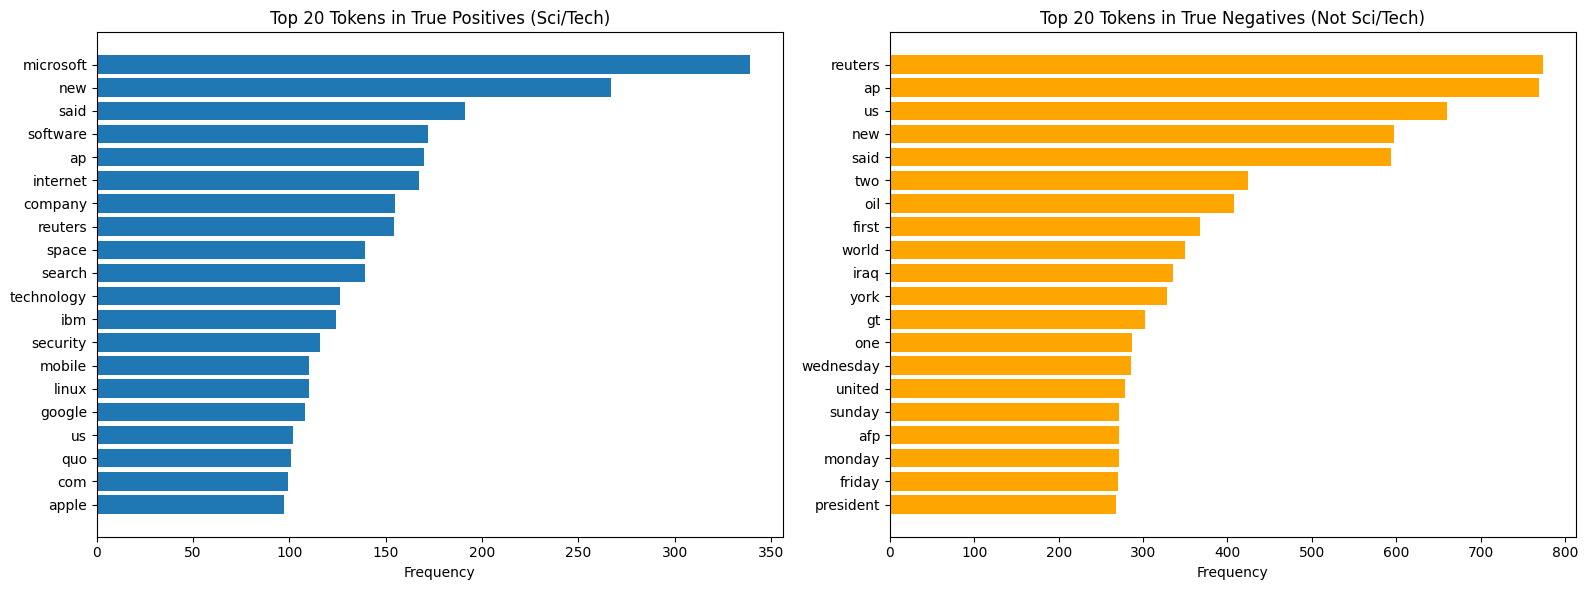

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

# Load your cleaned AG News CSV file
df = pd.read_csv('cleaned_agnews_pruned.csv')

# Clean NaNs
df = df.dropna(subset=['cleaned_remaining_sentence'])

# Example: Let's compare Science/Tech (e.g., Sports) predictions
# You can modify this depending on what classes you're interested in

# True Positives for Science/Tech
true_positives = df[(df['true_label'] == 3) & (df['predicted_label'] == 3)]

# True Negatives for Science/Tech — everything else correctly predicted that's not Science/Tech
true_negatives = df[(df['true_label'] != 3) & (df['true_label'] == df['predicted_label'])]

def get_top_tokens(dataframe, column='cleaned_remaining_sentence', top_k=20):
    all_tokens = []
    for sent in dataframe[column]:
        tokens = sent.lower().strip().split()
        all_tokens.extend(tokens)
    counter = Counter(all_tokens)
    return counter.most_common(top_k)

# Get top tokens
tp_top_tokens = get_top_tokens(true_positives)
tn_top_tokens = get_top_tokens(true_negatives)

# Save token counts to CSV
os.makedirs("results_agnews/token_counts", exist_ok=True)
pd.DataFrame(tp_top_tokens, columns=["token", "frequency"]).to_csv("results_agnews/token_counts/true_positives_class2_top20.csv", index=False)
pd.DataFrame(tn_top_tokens, columns=["token", "frequency"]).to_csv("results_agnews/token_counts/true_negatives_class2_top20.csv", index=False)

# Unpack for plotting
tp_tokens, tp_counts = zip(*tp_top_tokens) if tp_top_tokens else ([], [])
tn_tokens, tn_counts = zip(*tn_top_tokens) if tn_top_tokens else ([], [])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(range(len(tp_tokens)), tp_counts, align='center')
axes[0].set_yticks(range(len(tp_tokens)))
axes[0].set_yticklabels(tp_tokens)
axes[0].set_title("Top 20 Tokens in True Positives (Sci/Tech)")
axes[0].invert_yaxis()
axes[0].set_xlabel("Frequency")

axes[1].barh(range(len(tn_tokens)), tn_counts, color='orange', align='center')
axes[1].set_yticks(range(len(tn_tokens)))
axes[1].set_yticklabels(tn_tokens)
axes[1].set_title("Top 20 Tokens in True Negatives (Not Sci/Tech)")
axes[1].invert_yaxis()
axes[1].set_xlabel("Frequency")

plt.tight_layout()
os.makedirs("results_agnews/plots", exist_ok=True)
plt.savefig("results_agnews/plots/top20_tokens_TP_TN_class3.png")
plt.show()

## 2. Word Cloud

### Correct Predictions

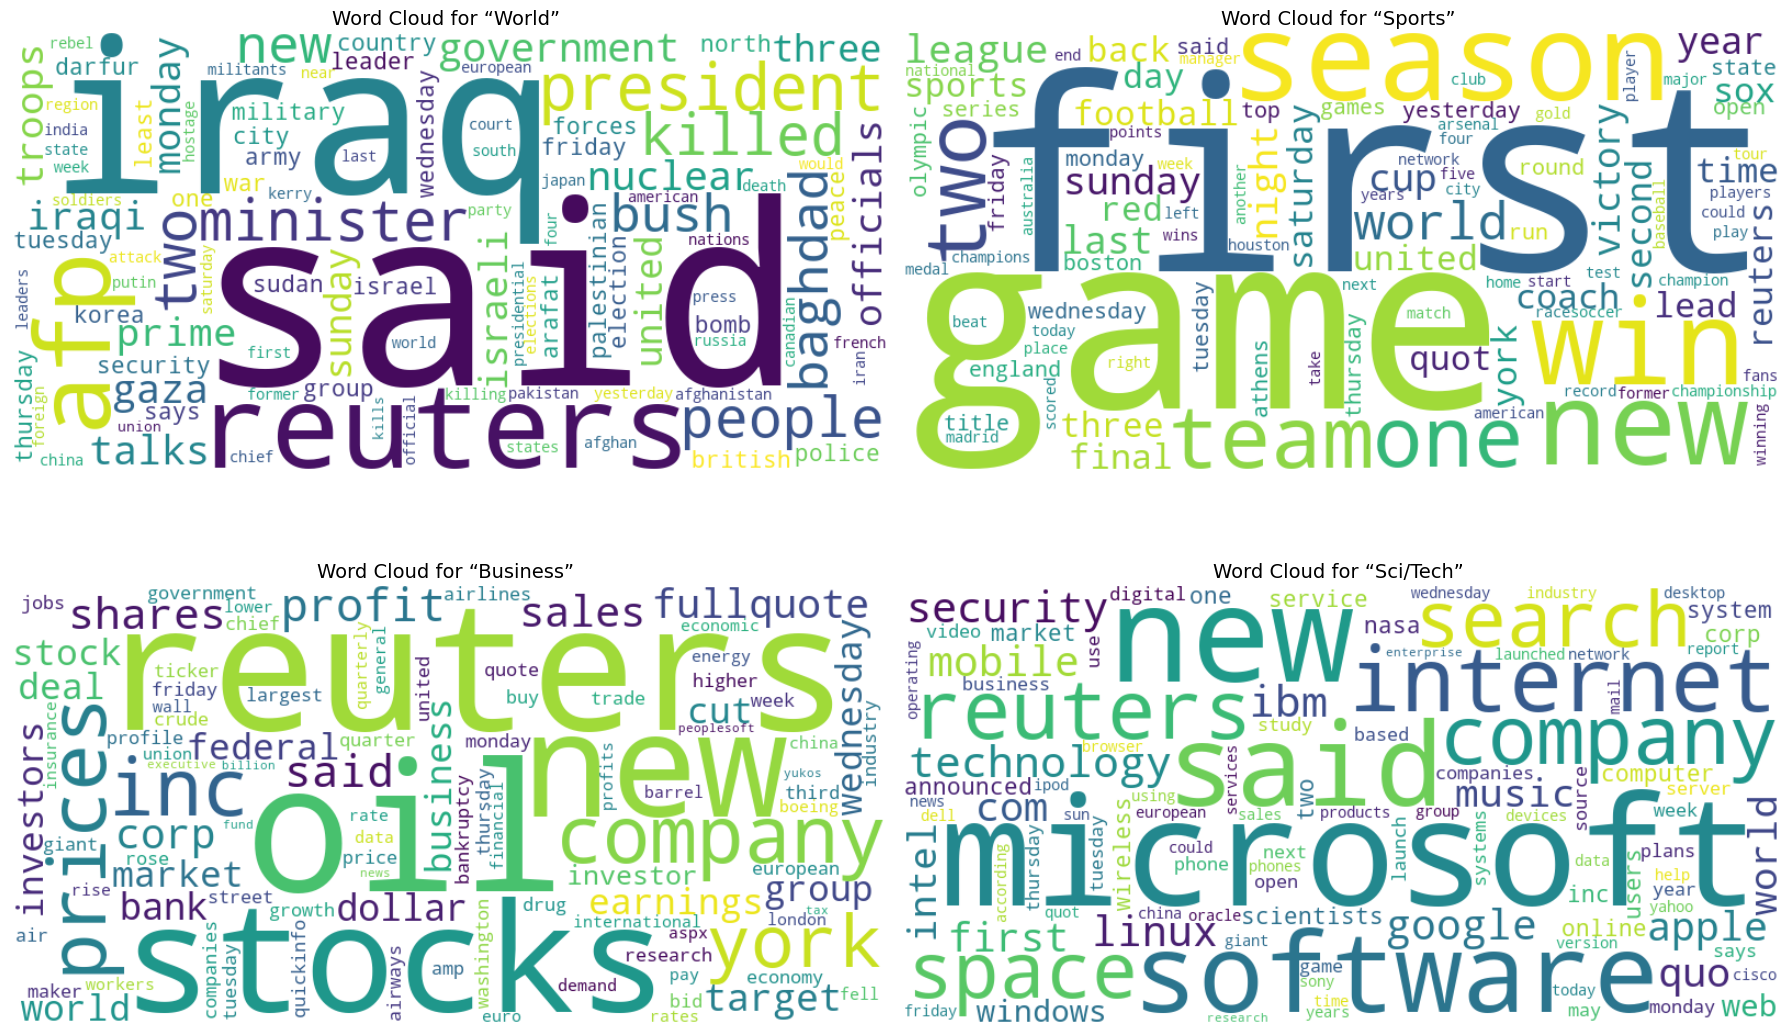

In [36]:

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load dataset
df = pd.read_csv('cleaned_agnews_pruned.csv')

# Filter correct predictions
df = df[df['true_label'] == df['predicted_label']]

# Preprocess: tokenize and filter
df['retained_list'] = df['cleaned_remaining_sentence'].str.split()
df['filtered_retained'] = df['retained_list'].apply(
    lambda toks: [t.lower() for t in toks if t.isalpha() and len(t) > 2]
)

# Label map
label_names = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}

# Set up 2x2 plot grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, label in enumerate(sorted(label_names)):
    # Create frequency dict for each class
    tokens = df[df['true_label'] == label]['filtered_retained'].explode()
    freq_dict = tokens.value_counts().to_dict()
    
    # Create word cloud from exact frequencies
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100
    ).generate_from_frequencies(freq_dict)
    
    # Plot
    axes[idx].imshow(wc, interpolation='bilinear')
    axes[idx].set_title(f"Word Cloud for “{label_names[label]}” ", fontsize=14)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig("results_agnews/wordclouds_by_class.png", dpi=300)
plt.show()

## 3. POS TAG Frequency

In [13]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/christomathew/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### generate the pos tag file

In [ ]:
import pandas as pd
import nltk
from nltk import word_tokenize

# Load your cleaned CSV
df = pd.read_csv('cleaned_agnews_pruned.csv')

# Drop NaNs if any
df = df.dropna(subset=['cleaned_remaining_sentence'])

# Ensure NLTK resources are available
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Function to perform POS tagging
def pos_tag_sentence(sentence):
    tokens = word_tokenize(sentence)
    pos_tags = nltk.pos_tag(tokens)
    return " ".join([f"{word}/{tag}" for word, tag in pos_tags])

# Apply POS tagging
df['pos_tags'] = df['cleaned_remaining_sentence'].apply(pos_tag_sentence)

# Save the updated DataFrame
df.to_csv('cleaned_agnews_pruned.csv', index=False)

print("✅ POS tagging complete. File updated: cleaned_agnews_pruned.csv")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christomathew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/christomathew/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


✅ POS tagging complete. File updated: cleaned_imdb_pruned.csv


### plot top 20 pos tags

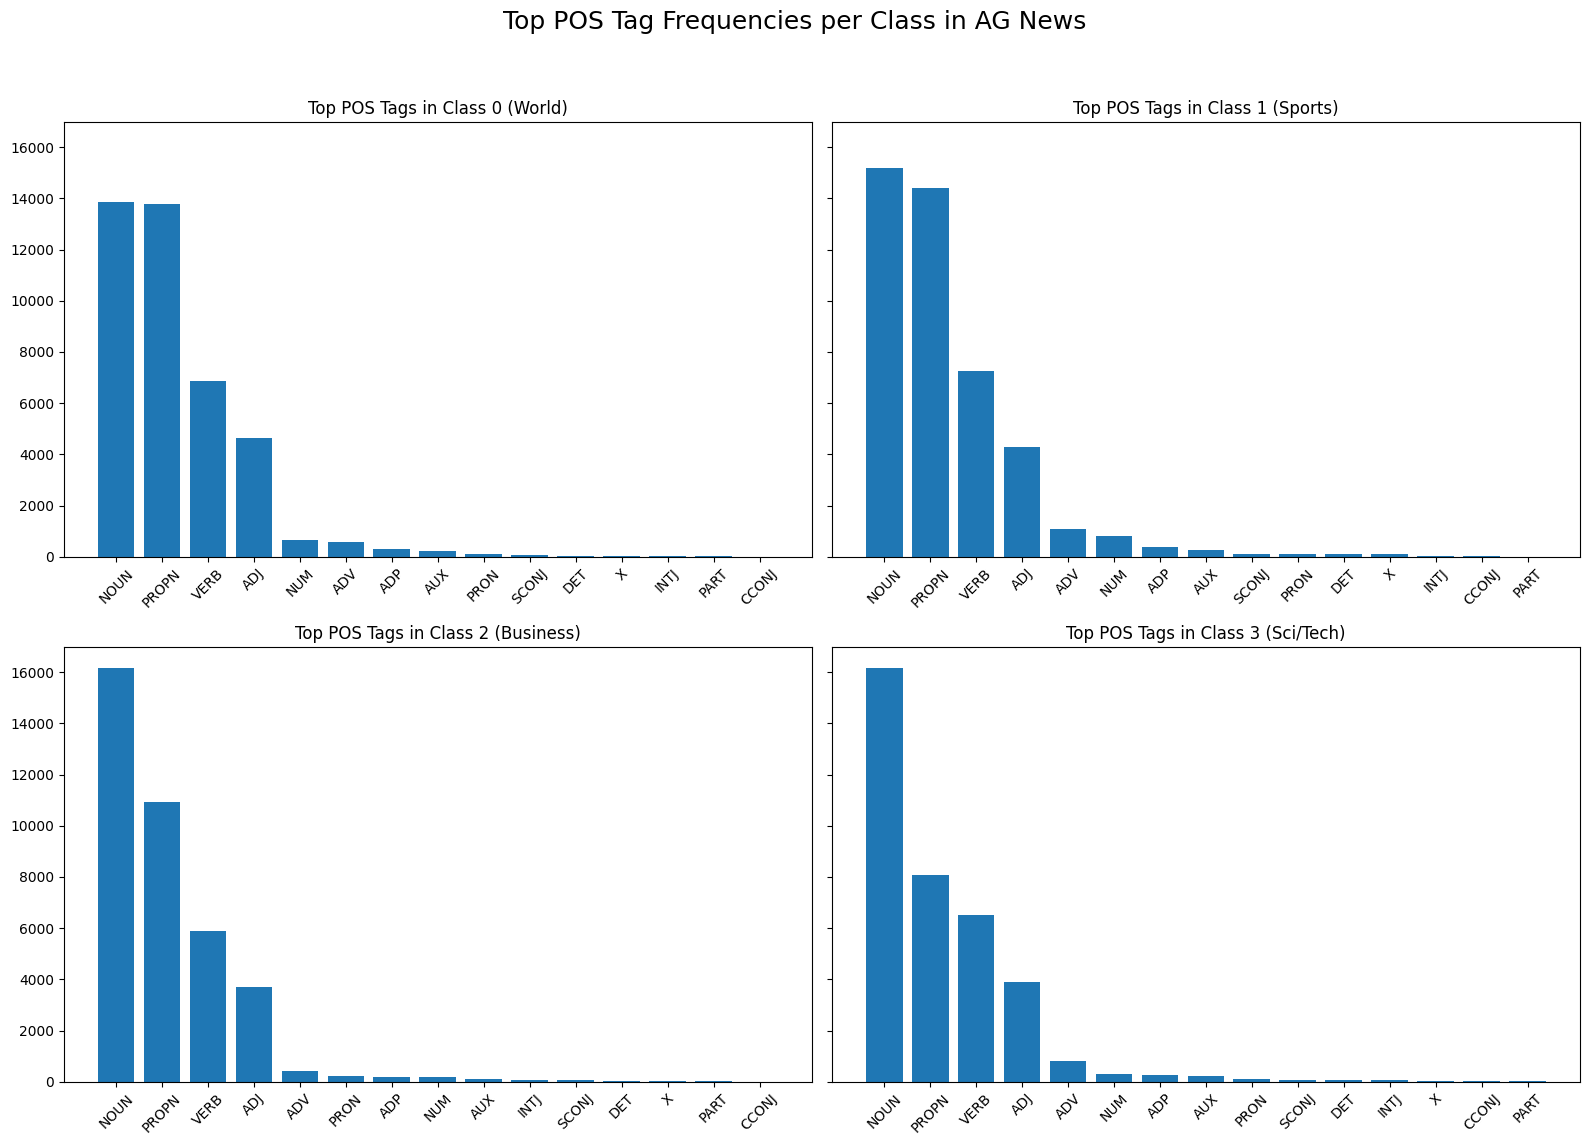

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import spacy
# Load the updated DataFrame
df = pd.read_csv('cleaned_imdb_pruned.csv')

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")  # Make sure this model is installed

# Load your cleaned CSV
df = pd.read_csv('cleaned_imdb_pruned.csv')

# Drop NaNs if any
df = df.dropna(subset=['cleaned_remaining_sentence'])
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")  # You can also use "en_core_web_md"

# Load cleaned AG News data
df = pd.read_csv('cleaned_agnews_pruned.csv')

# Drop NaNs
df = df.dropna(subset=['cleaned_remaining_sentence'])

# POS tagging using spaCy
def pos_tag_spacy(sentence):
    doc = nlp(sentence)
    return " ".join([f"{token.text}/{token.pos_}" for token in doc])

# Apply POS tagging (only if not already tagged)
if 'pos_tags' not in df.columns:
    df['pos_tags'] = df['cleaned_remaining_sentence'].apply(pos_tag_spacy)
    df.to_csv('cleaned_agnews_pruned.csv', index=False)

# Helper to extract POS tag frequencies
def get_pos_frequencies(pos_series, top_k=15):
    pos_list = []
    for tag_str in pos_series:
        pos_tags = [pair.rsplit('/', 1)[-1] for pair in tag_str.split()]
        pos_list.extend(pos_tags)
    return Counter(pos_list).most_common(top_k)

# Setup for class-wise POS tag plots
label_names = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
axes = axes.flatten()

for class_label in range(4):
    class_df = df[df['true_label'] == class_label]
    class_freq = get_pos_frequencies(class_df['pos_tags'])
    tags, counts = zip(*class_freq)
    
    axes[class_label].bar(tags, counts)
    axes[class_label].set_title(f"Top POS Tags in Class {class_label} ({label_names[class_label]})")
    axes[class_label].tick_params(axis='x', rotation=45)

plt.suptitle("Top POS Tag Frequencies per Class in AG News", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("results_agnews/plots/top_pos_tags_by_class.png", dpi=300)
plt.show()


### T-SNE

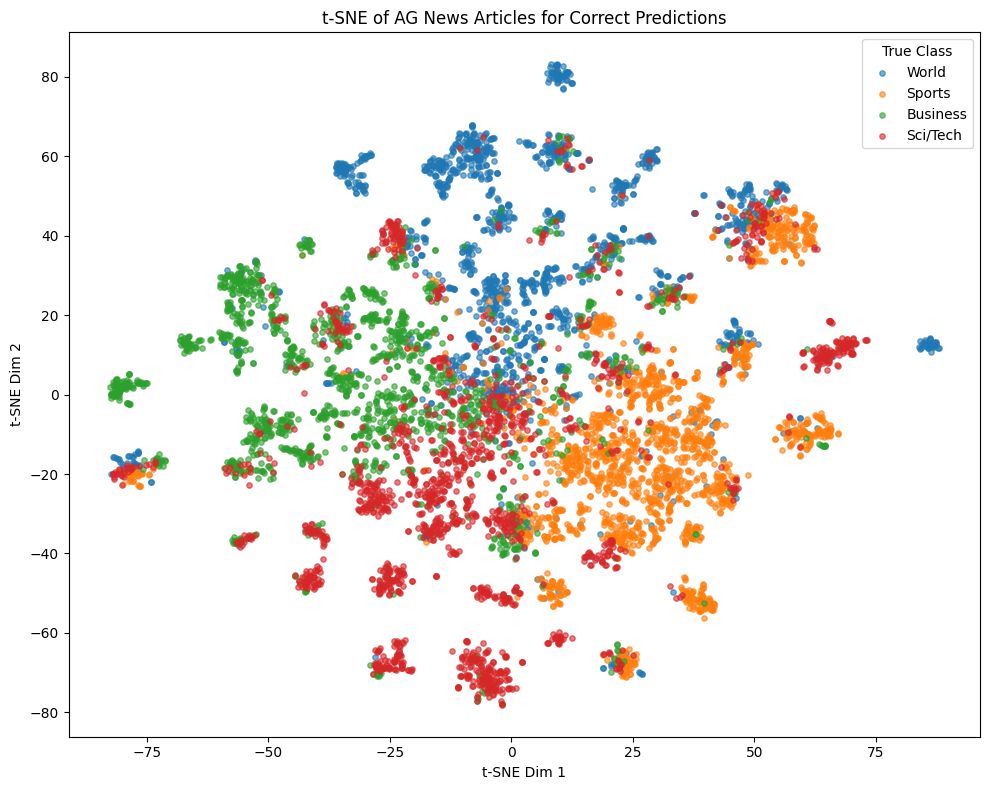

In [38]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Load AG News data
df = pd.read_csv('cleaned_agnews_pruned.csv')

# 2. Keep only correct predictions
df = df[df['predicted_label'] == df['true_label']]

# 3. Tokenize and create document string
df['retained_list'] = df['cleaned_remaining_sentence'].str.split()
df['doc_str'] = df['retained_list'].apply(lambda toks: ' '.join(toks))

# 4. (Optional) Sample for faster visualization
# df = df.sample(n=2000, random_state=42)

# 5. TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['doc_str'])

# 6. Reduce dimensions with SVD
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

# 7. t-SNE projection
tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
X_embedded = tsne.fit_transform(X_reduced)

# 8. Plot with class labels
label_names = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

plt.figure(figsize=(10, 8))
for lbl, name in label_names.items():
    idx = df['true_label'] == lbl
    plt.scatter(
        X_embedded[idx, 0],
        X_embedded[idx, 1],
        s=15,
        alpha=0.6,
        label=name
    )

plt.legend(title="True Class")
plt.title("t-SNE of AG News Articles for Correct Predictions")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.savefig("results_agnews/plots/tsne_agnews_correct_predictions.png", dpi=300)
plt.show()

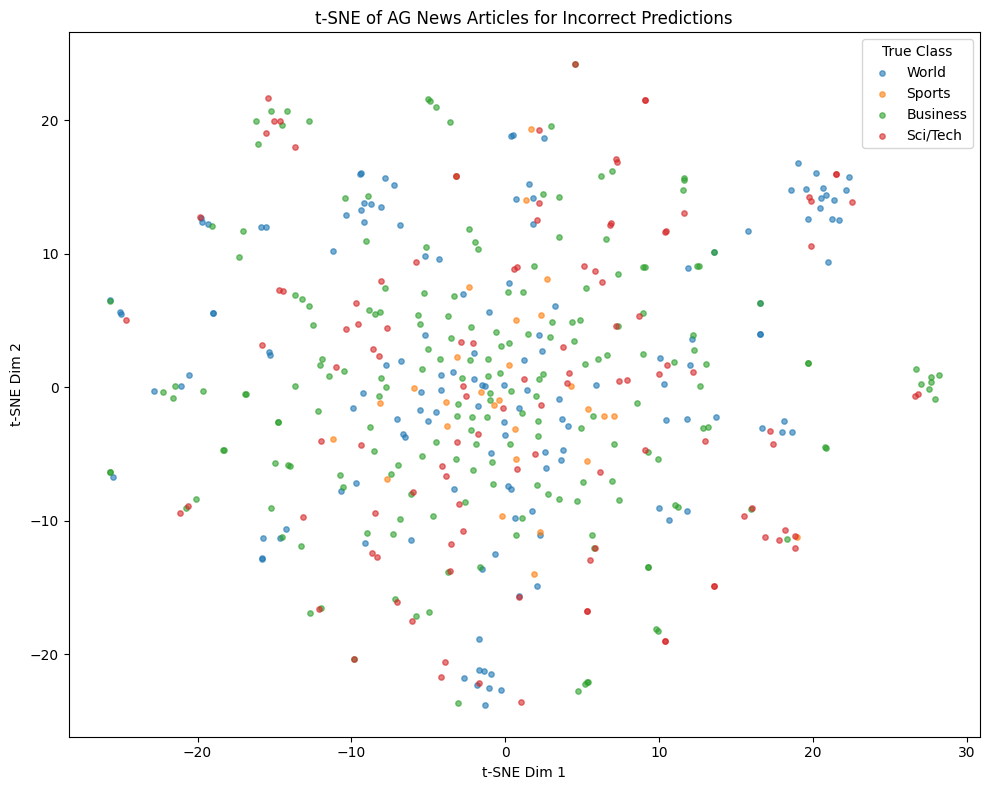

In [39]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Load AG News data
df = pd.read_csv('cleaned_agnews_pruned.csv')

# 2. Filter incorrect predictions
df = df[df['predicted_label'] != df['true_label']]

# 3. Tokenize retained sentence
df['retained_list'] = df['cleaned_remaining_sentence'].str.split()
df['doc_str'] = df['retained_list'].apply(lambda toks: ' '.join(toks))

# (Optional) Subsample to speed up computation
# df = df.sample(n=2000, random_state=42)

# 4. TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['doc_str'])

# 5. Dimensionality reduction with SVD
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

# 6. Compute t-SNE embeddings
tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
X_embedded = tsne.fit_transform(X_reduced)

# 7. Plot colored by true class
label_names = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

plt.figure(figsize=(10, 8))
for lbl, name in label_names.items():
    idx = df['true_label'] == lbl
    plt.scatter(
        X_embedded[idx, 0],
        X_embedded[idx, 1],
        s=15,
        alpha=0.6,
        label=name
    )

plt.legend(title="True Class")
plt.title("t-SNE of AG News Articles for Incorrect Predictions")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.savefig("results_agnews/plots/tsne_agnews_incorrect_predictions.png", dpi=300)
plt.show()